# **PneumoniaMNIST with Quanvolution 2×2**
### *Universidad Nacional Autónoma de México*
## Laboratorio Avanzado de Procesamiento de Imágenes
Académicos:
* Dr. Boris Escalante Ramírez

### Autor: **Sebastián González Juárez**

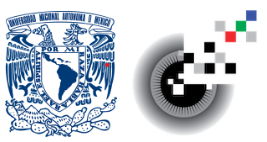

### **Resumen:**

Este código trae su explicación en el documento PneumoniaMNIST_with_Quanvolution_2×2, el objetivo fue tratar la idea de las Quanvoluciones a un problema con mayor cantidad de imágenes y una dimensionalidad mayor (a comparación del código anterior). Para ello he propuesto el conjunto neumonía de MedMnist que cuenta con más de 5 mil imágenes con un tamaño de 28x28 píxeles.

La presente red neuronal cántica forma parte de una colección de versiones, 6 en total, que difieren en su elección de parámetros. Entre las versiones encontramos 2 principales cambios que son trabajar con todo el conjunto de 28x28 y el otro que hace una reducción a 14x14, cada versión tiene 3 juegos de parámetros en total. 

Sugiero enormemente, para una mejor comprensión del código, acompañar su lectura con el documento explicativo PneumoniaMNIST


**A3 (28×28, 12 épocas, batch=16, LR=3e−3, WD=1e−4).** 

Entrenamiento con pérdida bajando (0.11→0.045) y exactitud ~96–97%. En validación, @0.5 alcanzó acc=95.6%, F1=0.970; con @thr*=0.756 logró acc=96.4%, F1=0.976, AUC hasta 0.993 (mejor estado: val_loss=0.0585). En prueba, @0.5 dio loss=0.4076, acc=88.3%, F1=0.912, prec=0.859, rec=0.972, AUC=0.944 (PR-AUC=0.940); con @thr*=0.756 mejoró acc=90.2%, F1=0.924 con prec=0.898, rec=0.951. Sesgo: favorece Neumonía; calibrar al thr* reduce falsos positivos y mejora precisión en Sano. 

Conclusión: estable y con la mejor validación de las A; la calibración de umbral entrega el mejor balance en test.

### Importaciones y paqueterías:

Para las secciones de cómputo clásico, utilizaremos las siguientes paqueterías ya conocidas y nuestro conjunto de datos a estudiar:

In [1]:
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from medmnist import INFO, PneumoniaMNIST
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score
)

Utilizaremos PennyLane para construir el circuito cuántico variacional que se integran con PyTorch:

In [2]:
import pennylane as qml

Fijemos la una semilla para reproducibilidad:

In [3]:
SEED = 87
np.random.seed(SEED)
torch.manual_seed(SEED)

En mi caso trabajo con CPU:

In [4]:
DEVICE = torch.device("cpu")
DEVICE

device(type='cpu')

## **1) Hiperparámetros y configuración del experimento.**

El conjunto PneumoniaMNIST es binario y se define como:  0 = sano, 1 = neumonía.

In [5]:
CLASS_POS = 1
CLASS_NEG = 0

En el siguiente bloque podemos elegir la configuración del entrenamiento. He obtado por dejarla así pues he obtenido buenos resutlados con eso y en código anteriores que usaban una idea similar, presentaron muy buen avance en las épocas:

In [6]:
BATCH_SIZE   = 16
EPOCHS       = 12
LR           = 3e-3
WEIGHT_DECAY = 1e-4

Ahora debemos elegir los parámetros para llevar a cabo la Quanvolution, pero hay que considerar que la idea es reducir la imagen 28×28 → 14×14 (con AvgPool en otra sección) y luego aplicar parches 2×2 sin traslape, obtteniendo 7×7 = 49 parches por imagen.

In [7]:
PATCH_SIZE   = 2
QUBITS       = PATCH_SIZE * PATCH_SIZE
LAYERS       = 2                       # Este es el núm. de capas el VQA.

En este código se propone usar "adjoint", el cual es un método de diferenciación para PennyLane, con el buscamos entrenar nuestro circuito cuántico variacional de forma rápida y exacta en simulación. En Scripts pasados hemos presentado como sería con parameter-shift, lo cual representa de mejor forma el hardware cuántico. 

En este caso el cálculo determinista de expectativas, no funciona con muestreo estadístico y es por eso que tenemos: SHOTS=None.

In [8]:
DIFF_METHOD  = "adjoint"
SHOTS        = None

En el pdf de este ipynb desarrollamos más este tema. Sin embargo, quiero recalcar que el no usar SHOTS fue con la intensión de acelerar el proceso y reducir el trabajo de cómputo para probar la Quanvolution 2x2. Así que más que simulación, tenemos algo más exácto.

También, contamos con una Cabeza clásica posterior a la capa cuántica, la cual fue basada en el código de Quanvolution 2x2 para el conjunto DIGITS (incluido en mi GitHub):

In [9]:
USE_GAP      = False                     # Flatten + MLP
DROPOUT_P    = 0.20
OUT_DIM      = 1

## **2) Preparación y carga de datos (MedMNIST: PneumoniaMNIST):**

Vamos a pasar cada imagen a tensor PyTorch float32 y hacemos una normalización de [0,255] a [0,1]. Este canal creado es la escala de grises, así la forma final es: (1,28,28).

In [10]:
tf = transforms.Compose([transforms.ToTensor()])

Descargargamos y crea los tres splits del dataset PneumoniaMNIST. Luego de eso se aplica tf ya devuelve tensores normalizados.

In [11]:
train_set = PneumoniaMNIST(split='train', transform=tf, download=True)
val_set   = PneumoniaMNIST(split='val',   transform=tf, download=True)
test_set  = PneumoniaMNIST(split='test',  transform=tf, download=True)

La función to_tensors() va a recorree todo el dataset y convertirá los elementos a tensores PyTorch: apila las imágenes en un único tensor xs de tipo float32 y forma (N,1,28,28), y crea un tensor ys con las etiquetas como enteros garantizando que cada una sea un escalar Python, lo que evita advertencias de conversión y permite tener todo el conjunto en memoria para acelerar el entrenamiento.

In [12]:
def to_tensors(ds):
    xs = torch.stack([ (ds[i][0] if isinstance(ds[i][0], torch.Tensor) else torch.as_tensor(ds[i][0])) .float()
                       for i in range(len(ds)) ], dim=0)  # (N,1,28,28)
    ys = torch.tensor([ (ds[i][1].item() if hasattr(ds[i][1], "item") else np.asarray(ds[i][1]).item())
                        for i in range(len(ds)) ], dtype=torch.long)          # (N,)
    return xs, ys

X_tr, y_tr = to_tensors(train_set)
X_va, y_va = to_tensors(val_set)
X_te, y_te = to_tensors(test_set)

Procedemos a crear los DataLoaders que dividen el dataset en minilotes (batch_size) y permiten iterar fácilmente durante el entrenamiento.

Notemos que usamos shuffle=True solo en entrenamiento para mezclar los datos y mejorar la capacidad de generalización del modelo, mientras que en validación y prueba se mantiene el orden fijo para obtener evaluaciones consistentes.

In [13]:
train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_va, y_va), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_te, y_te), batch_size=BATCH_SIZE, shuffle=False)

Mostremos la información de dimensionalidad que hemos generado para el conjunto:

In [14]:
print(f"Train: {len(train_loader.dataset)} | Val: {len(val_loader.dataset)} | Test: {len(test_loader.dataset)}")
print("Ejemplo shape batch:", next(iter(train_loader))[0].shape)

Train: 4708 | Val: 524 | Test: 624
Ejemplo shape batch: torch.Size([16, 1, 28, 28])


Visualicemos el conjunto de imágenes:

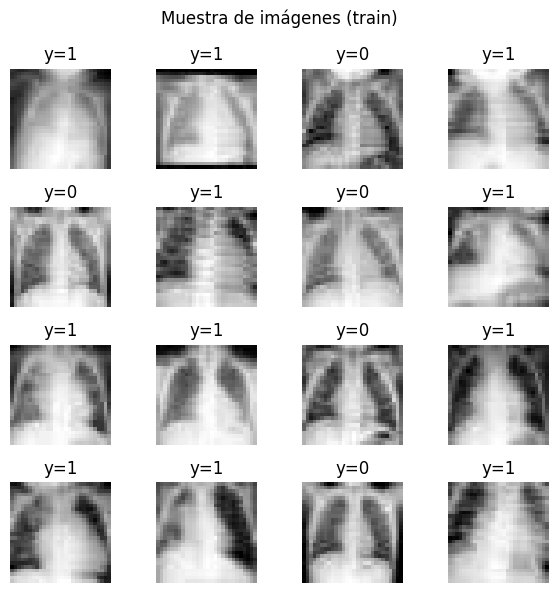

In [15]:
imgs, ys = next(iter(train_loader))
ys_int = ys.squeeze().long()
grid = imgs[:16]
fig, axs = plt.subplots(4,4, figsize=(6,6))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(grid[i,0].numpy(), cmap='gray')
    ax.set_title(f"y={int(ys_int[i].item())}")
    ax.axis('off')
plt.suptitle("Muestra de imágenes (train)")
plt.tight_layout(); plt.show()

## **3) Dispositivo y QNode (adjoint, sin shots).**

Vamos a definirel circuito cuántico variacional, este cuenta con las siguientes secciones:
    
    (a) Embedding: Es un mapeo de el parche 2×2 a rotaciones RY(φ) por qubit; cada ángulo φ viene de los píxeles normalizados.
    
    (b) Ansatz variacional: Es la capa de aprendizaje, donde se modifica dependiendo de los LAYERS. Contamos para cada qubit las compuertas RY(θ_y), RZ(θ_z) y un anillo de CNOTs (0→1→2→3→0) para entrelazar los 4 qubits.

    (c) Lectura: Hacemos lectura de las expectativas ⟨Z⟩ por qubit, una lista de 4 valores en [-1,1].

Emepzamos creando el simulador de estado vectorial con QUBITS en PennyLane. Recordando que SHOTS=None, lo que nos llevaba a que el cálculo es determinista:

In [16]:
dev = qml.device("default.qubit", wires=QUBITS, shots=SHOTS)

En esta sección integramos a el circuito PyTorch para hacer backprop. Por otro lado recordemos que diff_method="adjoint", lo que llevaba a tener gradientes analíticos y rápidos en simulación:

In [17]:
@qml.qnode(dev, interface="torch", diff_method=DIFF_METHOD)
def quanv_circuit(x_angles, weights):
    # (a) Embedding: RY(φ) por qubit
    for w in range(QUBITS):
        qml.RY(x_angles[w], wires=w)
    # (b) Ansatz: [RY(θ_y), RZ(θ_z)] por qubit + anillo CNOT
    for l in range(LAYERS):
        for w in range(QUBITS):
            qml.RY(weights[l, w, 0], wires=w)
            qml.RZ(weights[l, w, 1], wires=w)
        qml.CNOT(wires=[0,1]); qml.CNOT(wires=[1,2]); qml.CNOT(wires=[2,3]); qml.CNOT(wires=[3,0])
    # (c) Medición: ⟨Z⟩ por qubit
    return [qml.expval(qml.PauliZ(w)) for w in range(QUBITS)]

## **4) Capas quanvolucionales 2×2.** (2 variantes)

### Variante A: Quanv2x2_28 (entrada 28×28 → salida 4×14×14):

Esta capa toma cada parche 2×2 de la imagen, lo codifica en el circuito cuántico con pesos compartidos, y devuelve un mapa de 4 canales (14×14) con las características cuánticas ⟨Z⟩ que luego consumirá la parte clásica del modelo. A continuación lo explico por partes:

**def __init__(self):**
- La función declara los parámetros cuánticos compartidos en un tensor i. e. por cada capa variacional (LAYERS) y por cada qubit (QUBITS=4), hay dos ángulos entrenables (uno para RY y otro para RZ) los cuales se inicializan pequeños para estabilidad.

**def forward(self, x):**
- Realizamos un chequeo de forma que garantiza que la entrada sea monocanal 28×28.

1. Tomamos las “ventanas” 2×2 y las aplanamos en un canal, así salen 4 valores por parche y 196 parches por imagen.
2. Pasamos a convertir el tensor en una matriz donde cada fila es un parche con sus 4 píxeles (1 por qubit).
3. Mapeamos las intensidades [0,1] a ángulos [0,π] para usarlos en RY(φ) (embedding por qubit).
4. Ahora si para cada parche se ejecuta el QNode con los mismos pesos (self.weights) y obtiene 4 expectativas ⟨Z⟩ (una por qubit). Esto implementa la compartición de pesos.
5. Reordenamos la lista lineal de parches a un tensor imagen con 4 canales y tamaño 14×14 (un canal por qubit).
6. Nos aseguramos que el dtype coincida con la entrada y se muestra una sola vez un mensaje útil para revisar tipos.

In [18]:
class Quanv2x2_28(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(0.1 * torch.randn(LAYERS, QUBITS, 2))
        self._dbg_printed = False

    def forward(self, x):
        B, C, H, W = x.shape
        assert C == 1 and H == 28 and W == 28, "Esperaba (B,1,28,28)."
        # (1) Extraer parches 2x2 no solapados: (B, 4, 196)
        patches = F.unfold(x, kernel_size=PATCH_SIZE, stride=PATCH_SIZE)
        # (2) Reordenar a una lista de parches (B*196, 4)
        patches = patches.transpose(1, 2).reshape(-1, QUBITS)
        # (3) Escalado a ángulos: φ = π·x (mantiene dtype torch)
        angles = torch.pi * patches
        # (4) Aplicar el circuito cuántico QNode por parche (con los parámetros compartidos)
        outs = []
        for i in range(angles.shape[0]):
            z_i = quanv_circuit(angles[i], self.weights)    # lista de 4 tensores
            outs.append(torch.stack(z_i))                   # (4,)
        outs = torch.stack(outs, dim=0)                     # (B*196, 4)
        # (5) Reconstrucción del mapa de características con rearmado: (B, 4, 14, 14)
        outs = outs.reshape(B, 196, QUBITS).permute(0, 2, 1).reshape(B, QUBITS, 14, 14)
        # (6) Consistencia de tipos + print de depuración
        outs = outs.to(x.dtype)
        if not self._dbg_printed:
            print("Quanv dtype in/out:", x.dtype, "→", outs.dtype)
            self._dbg_printed = True
        return outs

### Variante B: Quanv2x2_14 (entrada 14×14 → salida 4×7×7):
Esta capa recibe una imagen preprocesada de 14×14 (tras el pre-pooling), toma cada parche 2×2 y lo pasa por el mismo circuito cuántico variacional con pesos compartidos. Devuelve un mapa de 4 canales (7×7) donde cada canal representa la expectativa ⟨Z⟩ de un qubit, es decir, las características cuánticas que alimentarán a la parte clásica del modelo. A continuación se explica cada componente:

**def init(self):**
- Se definen los parámetros cuánticos compartidos en un tensor de dimensiones (LAYERS, QUBITS, 2), donde para cada capa variacional y para cada qubit hay dos ángulos entrenables (uno asociado a RY y otro a RZ). Estos se inicializan con valores pequeños (0.1·N(0,1)) para garantizar estabilidad durante el entrenamiento.

**def forward(self, x):**
- Se realiza un chequeo de forma para asegurarse de que la entrada sea monocanal y tenga dimensiones (B, 1, 14, 14); esto confirma que se aplicó correctamente el pre-pooling.

1. Se extraen los parches 2×2 sin solaparse mediante F.unfold, generando 49 parches por imagen y 4 valores por parche.
2. El tensor se reorganiza en una matriz de forma (B*49, 4) para que cada fila corresponda a un parche y cada columna a un qubit.
3. Las intensidades de píxel [0, 1] se escalan a [0, π] para codificarlas en rotaciones RY(φ), actuando como embedding cuántico.
4. Cada parche se pasa por el QNode usando los mismos pesos (self.weights); el circuito devuelve 4 expectativas ⟨Z⟩ (una por qubit). Esto implementa la compartición de pesos, análoga a una convolución clásica.
5. Los resultados se reordenan para formar un mapa de características con 4 canales y dimensiones 7×7 — un canal por qubit.
6. Finalmente, se asegura que el tipo de dato de salida sea idéntico al de entrada y se imprime una vez el mensaje de depuración de tipos.

In [ ]:
class Quanv2x2_14(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(0.1 * torch.randn(LAYERS, QUBITS, 2))
        self._dbg_printed = False

    def forward(self, x):
        B, C, H, W = x.shape
        assert C == 1 and H == 14 and W == 14, "Esperaba (B,1,14,14) tras pre-pooling."
        # (1) Extraer parches 2x2 no solapados: (B,4,49)
        patches = F.unfold(x, kernel_size=2, stride=2)
        # (2) Reordenar a (B*49, 4)
        patches = patches.transpose(1, 2).reshape(-1, QUBITS)
        # (3) φ = π·x (mantiene dtype)
        angles = torch.pi * patches
        # (4) QNode por parche (parámetros compartidos)
        outs = []
        for i in range(angles.shape[0]):
            z_i = quanv_circuit(angles[i], self.weights)   # lista de 4 tensores
            outs.append(torch.stack(z_i))                   # (4,)
        outs = torch.stack(outs, dim=0)                    # (B*49, 4)
        # (5) Rearmado: (B, 4, 7, 7)
        outs = outs.reshape(B, 49, QUBITS).permute(0, 2, 1).reshape(B, QUBITS, 7, 7)
        # (6) Consistencia de tipos
        outs = outs.to(x.dtype)
        if not self._dbg_printed:
            print("Quanv dtype in/out:", x.dtype, "→", outs.dtype)
            self._dbg_printed = True
        return outs


## **5) Cabezas clásicas: Flatten + MLP.** (2 variantes)

**(IMPORTANTE: EJECUTA SOLO LA VARIANTE QUE OCUPES, NO LAS DOS)**

### Variante A: HeadSmall (entrada 4×14×14 → salida logit (B,1)):
Esta clase actúa como la cabeza clásica del modelo híbrido: recibe el mapa de características cuánticas de forma (B, 4, 14, 14) y lo transforma en un logit (B, 1) a través de un pequeño perceptrón multicapa (MLP) con una capa oculta, activación ReLU y dropout. Esta parte del modelo es la responsable de realizar la decisión final de clasificación binaria.

**def __init__(self, p_dropout: float = 0.20):**

Se definen tres bloques:

- Una capa lineal Linear(4*14*14, 64) que aplana implícitamente las 784 características del mapa cuántico y las proyecta a un espacio latente de 64 neuronas, compactando la información.
- Una capa Dropout(p=0.20) que desactiva aleatoriamente el 20% de las neuronas durante el entrenamiento, reduciendo el sobreajuste.
- Una capa final Linear(64, OUT_DIM) que proyecta el vector oculto al logit de salida (B,1), usado con BCEWithLogitsLoss para clasificación binaria.

**def forward(self, z):**
1. Se realiza un Flatten explícito del tensor de entrada (B, 4, 14, 14) a (B, 784).

2. Se aplica la capa oculta seguida de una activación ReLU, introduciendo no linealidad y mejorando la capacidad de representación.

3. Se aplica dropout para regularizar la capa intermedia.

4. Finalmente, se devuelve el logit (B, 1) sin aplicar sigmoid (la función de activación se aplicará en las métricas o la pérdida).

*EJECUTAR SOLO SI USAS VERSIÓN A Y NO USAR LA B*

In [19]:
class HeadSmall(nn.Module):
    def __init__(self, p_dropout: float = 0.20):
        super().__init__()
        self.hidden  = nn.Linear(4*14*14, 64)  # 784 → 64
        self.dropout = nn.Dropout(p=p_dropout)
        self.fc      = nn.Linear(64, OUT_DIM)  # 64 → 1 (logit)

    def forward(self, z):
        z = z.reshape(z.shape[0], -1)  # (B,784)
        z = F.relu(self.hidden(z))
        z = self.dropout(z)
        return self.fc(z)              # (B,1)

### Variante B: HeadSmall (entrada 4×7×7 → salida logit (B,1))

Esta versión de la cabeza clásica está adaptada a la arquitectura compacta del modelo, que tras el pre-pooling y la quanvolución genera un mapa cuántico más pequeño (B, 4, 7, 7). Mantiene la misma estructura conceptual, pero con menos parámetros, lo que la hace más eficiente y adecuada para ejecución en CPU.

**def __init__(self, p_dropout: float = 0.20):**

Tenemos las siguientes 3 capas:
- La primera capa Linear(4*7*7, 64) aplana las 196 características del mapa cuántico y las proyecta a 64 neuronas, conservando una representación comprimida de la información cuántica.
- Se usa Dropout(p=0.20) para desactivar aleatoriamente un 20% de las neuronas, reduciendo el sobreajuste y mejorando la robustez.
- La capa final Linear(64, OUT_DIM) proyecta el vector intermedio al logit binario (B,1), listo para BCEWithLogitsLoss.

**def forward(self, z):**
1. Se aplana el tensor (B, 4, 7, 7) a (B, 196).
2. Se aplica la capa oculta con activación ReLU, añadiendo no linealidad.
3. Se utiliza dropout para regularizar y mejorar la generalización del modelo.
4. Finalmente, se devuelve el logit (B,1), correspondiente a la probabilidad implícita de neumonía tras la activación sigmoide.

*EJECUTAR SOLO SI USAS VERSIÓN B Y NO USAR LA A*

In [ ]:
class HeadSmall(nn.Module):
    def __init__(self, p_dropout: float = 0.20):
        super().__init__()
        self.hidden  = nn.Linear(4*7*7, 64)  # 196 -> 64
        self.dropout = nn.Dropout(p=p_dropout)
        self.fc      = nn.Linear(64, OUT_DIM)

    def forward(self, z):
        z = z.reshape(z.shape[0], -1)  # (B,196)
        z = F.relu(self.hidden(z))
        z = self.dropout(z)
        return self.fc(z)              # (B,1)

## **6) Ensamble y selección de versión del modelo.**

En esta sección vamos a definir la arquitectura final del modelo cuántico-clásico, así como la opción para elegir entre las dos configuraciones disponibles:
* **Versión completa**: trabaja directamente sobre imágenes 28×28 y utiliza la capa Quanv2x2_28 junto con la cabeza HeadSmall(14×14).
* **Versión compacta**: aplica un pre-pooling 2×2 para reducir las imágenes a 14×14 antes de la quanvolución (Quanv2x2_14) y la cabeza HeadSmall(7×7).

In [20]:
# False -> Versión completa: Quanv2x2_28 + Head(14x14)
# True  -> Versión compacta: pre-pool 28->14 + Quanv2x2_14 + Head(7x7)

USE_PREPOOL = False

La siguiente clase sirve para la reducción llevabada en la versión compacta, donde:
- prepool: reduce la resolución de entrada 28×28 → 14×14 mediante promedio, lo que baja el número de parches de 196 a 49.
- quanv: aplica la quanvolución cuántica sobre 14×14 → (4, 7, 7).
- head: convierte el mapa cuántico reducido en un logit final (B,1).
- forward: ejecuta el flujo completo x → prepool → quanv → head.

In [21]:
class QuanvModel(nn.Module):
    def __init__(self, p_dropout: float = 0.20):
        super().__init__()
        self.prepool = nn.AvgPool2d(kernel_size=2, stride=2)  # 28->14
        self.quanv   = Quanv2x2_14()                          # (B,1,14,14)->(B,4,7,7)
        self.head    = HeadSmall(p_dropout=p_dropout)         # (B,4,7,7)->(B,1)

    def forward(self, x):
        x14 = self.prepool(x)  # (B,1,14,14)
        zq  = self.quanv(x14)
        return self.head(zq)

En base a lo que decidimos se contruye el modelo:

In [22]:
def build_model(use_prepool=True, p_dropout=DROPOUT_P):
    if use_prepool:
        # Versión compacta (requiere que HeadSmall sea la variante 7×7)
        return QuanvModel(p_dropout=p_dropout).to(DEVICE)
    else:
        # Versión completa (requiere que HeadSmall sea la variante 14×14)
        return nn.Sequential(
            Quanv2x2_28(),
            HeadSmall(p_dropout=p_dropout)
        ).to(DEVICE)

Instanciación y resumen de lo que realizamos:

In [23]:
model = build_model(USE_PREPOOL)
print(f"Modelo: {'Compacta (pre-pool + Quanv2x2_14 + Head7x7)' if USE_PREPOOL else 'Completa (Quanv2x2_28 + Head14x14)'}")
print("Parámetros totales:", sum(p.numel() for p in model.parameters()))

Modelo: Completa (Quanv2x2_28 + Head14x14)
Parámetros totales: 50321


## **7) Entrenamiento, validación (umbral óptimo) y test.**

**NOTA** - Compatibilidad con las versiones A y B. 

Esta sección funciona igual para ambas variantes del modelo (completa y compacta), ya que el entrenamiento y las métricas trabajan únicamente con los logits de salida (B, 1) y las etiquetas binarias (B,).

I. e. no importa si el modelo usa Quanv2x2_28 + Head(14×14) o Quanv2x2_14 + Head(7×7):
mientras devuelva un logit por muestra, las funciones de pérdida y evaluación operan de la misma manera.

Pasemos a revisar las partes de las que se compone está sección.

**7.1 — Criterio de pérdida y optimizador**

El objetivo es corregir el desbalance del dataset y estabilizar el entrenamiento con un optimizador adaptativo, los pasos son los siguientes:

1. Se calcula el peso de clase pos_weight según el desbalance entre positivos (neumonía) y negativos (sanos).

$$ pos_{weight} = 𝑛_{neg}/n_{pos}$$

    Este factor hace que los ejemplos minoritarios tengan más impacto en el gradiente.

2. Se usa BCEWithLogitsLoss, que combina internamente la sigmoide y la entropía cruzada, evitando problemas numéricos.

3. El optimizador es Adam con los hiperparámetros definidos (LR, WEIGHT_DECAY).

In [24]:
# 7.1) Criterio y optimizador (pos_weight a partir de y_tr definido antes)
with torch.no_grad():
    n_pos = int((y_tr == 1).sum())
    n_neg = int((y_tr == 0).sum())
pos_weight_val = n_neg / max(1, n_pos)
print(f"[Info] pos_weight (train): {pos_weight_val:.3f}  (pos={n_pos}, neg={n_neg})")

criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([pos_weight_val], device=DEVICE, dtype=torch.float32)
)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

[Info] pos_weight (train): 0.347  (pos=3494, neg=1214)


**7.2 — Entrenamiento por época (train_epoch)**

Vamos a ejecutar forward, backprop y optimización por lotes, registrando pérdida y precisión.

Esta función ejecuta una época completa de entrenamiento:
- Calcula los logits crudos (sin sigmoide) → pasa al criterio BCE.
- Convierte etiquetas a float y aplana (B,1) → (B,).
- Aplica clipping de gradiente (max_norm=1.0) para evitar inestabilidades derivadas del bloque cuántico.
- Devuelve el promedio de pérdida y la accuracy @ 0.5, usando logit ≥ 0 como predicción positiva.

In [25]:
# 7.2) Entrenamiento por época (E)
def train_epoch(dloader, print_every=20):
    model.train()
    tot_loss, tot_acc, tot_n = 0.0, 0.0, 0

    for it, (xb, yb) in enumerate(dloader, start=1):
        xb = xb.to(DEVICE)                   # (B,1,28,28)
        yb = yb.to(DEVICE).float().view(-1)  # (B,)

        logits = model(xb).view(-1)          # (B,)
        loss   = criterion(logits, yb)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # acc@0.5 (equivalente a logits >= 0)
        preds = (logits.detach() >= 0).float()
        acc = (preds == yb).float().mean().item()

        B = xb.size(0)
        tot_loss += loss.item() * B
        tot_acc  += acc * B
        tot_n    += B

        if it % print_every == 0:
            print(f"   · progreso: {tot_n} muestras procesadas en esta época")

    return tot_loss / max(1, tot_n), tot_acc / max(1, tot_n)

**7.3 — Validación y umbral óptimo (eval_epoch)**

Evalúa el modelo sin backpropagación, para  encontrar dinámicamente el umbral que mejor separa ambas clases y medir el rendimiento real del modelo:
- Recolecta logits y etiquetas en todo el conjunto.
- Aplica sigmoid para convertir logits en probabilidades.
- Calcula el umbral óptimo thr* según el índice de Youden J, que maximiza (TPR − FPR) sobre la curva ROC.
- Obtiene métricas a thr* y también a 0.5 para comparación: loss_prom, acc@thr*, AUC, F1@thr*, thr*, acc@0.5, F1@0.5.

In [26]:
# 7.3) Validación por época (F) — calcula umbral óptimo por Youden J
@torch.no_grad()
def _best_threshold(y_true, probs):
    try:
        fpr, tpr, thr = roc_curve(y_true, probs)
        j = tpr - fpr
        return float(thr[int(np.argmax(j))])
    except Exception:
        return 0.5


@torch.no_grad()
def eval_epoch(dloader):
    model.eval()
    tot_loss, tot_n = 0.0, 0
    logits_all, y_all = [], []

    for xb, yb in dloader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE).float().view(-1)

        logits = model(xb).view(-1)
        loss   = criterion(logits, yb)

        B = xb.size(0)
        tot_loss += loss.item() * B
        tot_n    += B

        logits_all.append(logits.detach().cpu())
        y_all.append(yb.detach().cpu())

    avg_loss = tot_loss / max(1, tot_n)

    logits = torch.cat(logits_all).float()
    y_true = torch.cat(y_all).numpy()
    probs  = torch.sigmoid(logits).numpy()

    # Métricas @thr*
    thr_star = _best_threshold(y_true, probs)
    y_hatS   = (probs >= thr_star).astype(np.int32)
    accS     = (y_hatS == y_true).mean()
    try:
        auc = roc_auc_score(y_true, probs)
    except ValueError:
        auc = float('nan')
    f1S = f1_score(y_true, y_hatS)

    # Métricas @0.5 (para graficar también val acc a umbral estándar)
    y_hat05 = (probs >= 0.5).astype(np.int32)
    acc05   = accuracy_score(y_true, y_hat05)
    f105    = f1_score(y_true, y_hat05)

    return avg_loss, accS, auc, f1S, thr_star, acc05, f105

**7.4 — Bucle principal de entrenamiento**

Ahora si se repite por EPOCHS, los ciclos implementan el entrenamiento completo con selección del mejor checkpoint según pérdida de validación:

- Llama a train_epoch(train_loader)
- Evalúa en validación con eval_epoch(val_loader)
- Guarda el mejor estado del modelo según val_loss.
- Almacena las métricas en el diccionario history para graficar después.

In [27]:
# 7.4) Loop de entrenamiento (G) — mejor estado por val_loss
history = {
    "tr_loss": [], "tr_acc05": [],
    "va_loss": [], "va_auc":  [],
    "va_acc_thr": [], "va_f1_thr": [], "va_thr": [],
    "va_acc05": [],  "va_f105": []
}

best_val_loss = float('inf')
best_state    = None
best_thr_val  = 0.5

for ep in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_epoch(train_loader)
    va_out = eval_epoch(val_loader)
    # desempaquetar con los nuevos elementos
    va_loss, va_acc_thr, va_auc, va_f1_thr, thr_star, va_acc05, va_f105 = va_out

    if va_loss < best_val_loss:
        best_val_loss = va_loss
        best_state    = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        best_thr_val  = thr_star

    # guardar historial para gráficas
    history["tr_loss"].append(tr_loss)
    history["tr_acc05"].append(tr_acc)
    history["va_loss"].append(va_loss)
    history["va_auc"].append(va_auc)
    history["va_acc_thr"].append(va_acc_thr)
    history["va_f1_thr"].append(va_f1_thr)
    history["va_thr"].append(thr_star)
    history["va_acc05"].append(va_acc05)
    history["va_f105"].append(va_f105)

    print(f"Época {ep:02d} | "
          f"Train: loss={tr_loss:.4f}, acc@0.5={tr_acc*100:.1f}% | "
          f"Val: loss={va_loss:.4f}, acc@thr*={va_acc_thr*100:.1f}%, AUC={va_auc:.3f}, F1={va_f1_thr:.3f}, thr*={thr_star:.3f} "
          f"| Val@0.5: acc={va_acc05*100:.1f}%, F1={va_f105:.3f}")

Quanv dtype in/out: torch.float32 → torch.float32
   · progreso: 320 muestras procesadas en esta época
   · progreso: 640 muestras procesadas en esta época
   · progreso: 960 muestras procesadas en esta época
   · progreso: 1280 muestras procesadas en esta época
   · progreso: 1600 muestras procesadas en esta época
   · progreso: 1920 muestras procesadas en esta época
   · progreso: 2240 muestras procesadas en esta época
   · progreso: 2560 muestras procesadas en esta época
   · progreso: 2880 muestras procesadas en esta época
   · progreso: 3200 muestras procesadas en esta época
   · progreso: 3520 muestras procesadas en esta época
   · progreso: 3840 muestras procesadas en esta época
   · progreso: 4160 muestras procesadas en esta época
   · progreso: 4480 muestras procesadas en esta época
Época 01 | Train: loss=0.1136, acc@0.5=91.3% | Val: loss=0.0808, acc@thr*=95.2%, AUC=0.985, F1=0.968, thr*=0.324 | Val@0.5: acc=93.1%, F1=0.953
   · progreso: 320 muestras procesadas en esta época


**7.5 — Evaluación en TEST con thr"*" con restauración**

Tras entrenar se obtiene el rendimiento final usando el umbral más apropiado aprendido durante la validación y obtenemos resultados:
- Restaura best_state (la red con menor pérdida de validación).
- Evalúa en test_loader usando best_thr_val.
- Calcula loss, acc@thr*, AUC y F1@thr*.
- Imprime los resultados finales de generalización del modelo.

**Nota**: Al final se repite de mejor manera esta parte, solo que al momento emepzara diseñar el código no existia la sección 8 y con está veía si era factible. Al final se me olvido moverla o retirarla, no hice la modificación para evitar los días que tarda en correr el código.

In [28]:
# 7.5) Restaurar mejor estado y evaluar en TEST con thr* (H)
@torch.no_grad()
def eval_with_threshold(dloader, threshold):
    model.eval()
    tot_loss, tot_n = 0.0, 0
    logits_all, y_all = [], []

    for xb, yb in dloader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE).float().view(-1)

        logits = model(xb).view(-1)
        loss   = criterion(logits, yb)

        B = xb.size(0)
        tot_loss += loss.item() * B
        tot_n    += B

        logits_all.append(logits.detach().cpu())
        y_all.append(yb.detach().cpu())

    avg_loss = tot_loss / max(1, tot_n)

    logits = torch.cat(logits_all).float()
    y_true = torch.cat(y_all).numpy()
    probs  = torch.sigmoid(logits).numpy()
    y_hat  = (probs >= float(threshold)).astype(np.int32)

    acc = (y_hat == y_true).mean()
    try:
        auc = roc_auc_score(y_true, probs)
    except ValueError:
        auc = float('nan')
    f1  = f1_score(y_true, y_hat)

    return avg_loss, acc, auc, f1

# Restaurar y evaluar
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(DEVICE)
    print(f"[Info] Restaurado mejor estado por val_loss = {best_val_loss:.4f}")
else:
    print("[Aviso] No hay 'best_state'; se evalúa el estado actual.")

te_loss, te_acc, te_auc, te_f1 = eval_with_threshold(test_loader, best_thr_val)
print(f"[TEST] loss={te_loss:.4f}, acc@thr*={te_acc*100:.1f}%, AUC={te_auc:.3f}, F1={te_f1:.3f}, thr*={best_thr_val:.3f}")



[Info] Restaurado mejor estado por val_loss = 0.0585
[TEST] loss=0.4076, acc@thr*=90.2%, AUC=0.944, F1=0.924, thr*=0.756


**7.6 — Gráficas de métricas**

Finalmente vamos a generan las curvas a lo largo de las épocas, lo cual nos va a permitir visualizar convergencia, estabilidad y evolución del criterio de decisión:
- Pérdida de entrenamiento vs validación.
- Accuracy: train @0.5, val @0.5 y val @ thr*.
- Métricas de validación: AUC, F1@0.5 y F1@ thr*.
- Evolución del umbral thr* (Youden J).

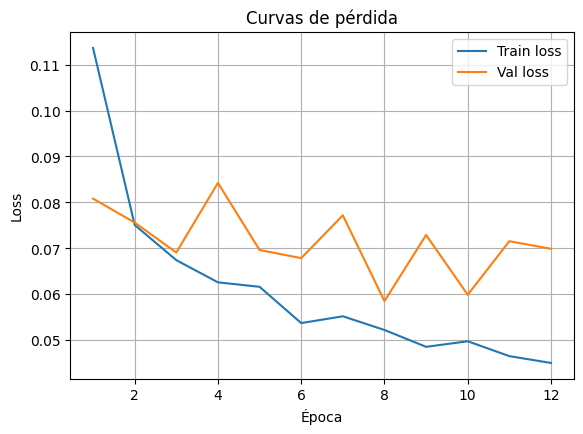

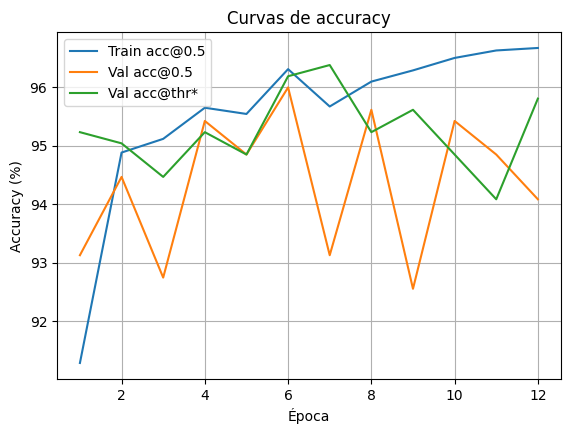

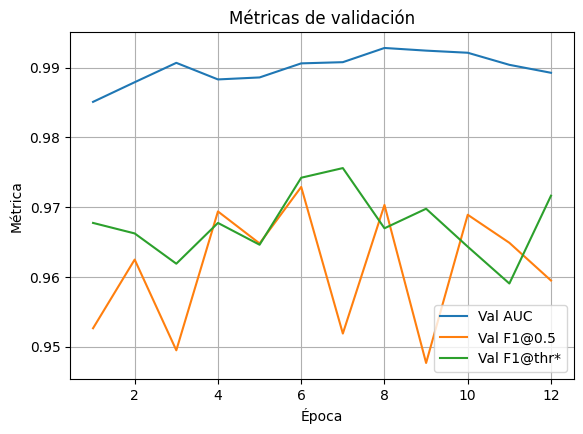

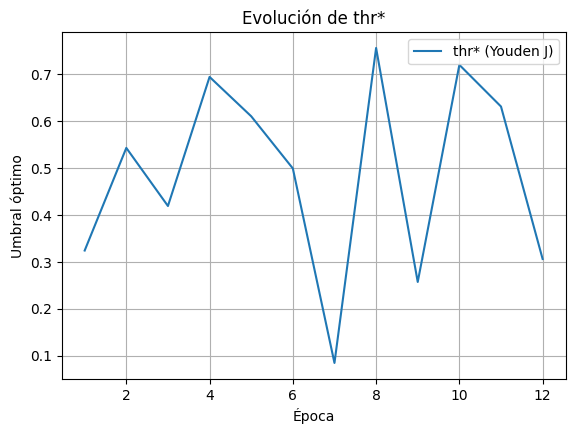

In [29]:
# 7.6) Gráficas de pérdida y accuracy (Train/Val)
import matplotlib.pyplot as plt

ep = np.arange(1, len(history["tr_loss"]) + 1)

plt.figure(figsize=(6.5,4.5))
plt.plot(ep, history["tr_loss"], label="Train loss")
plt.plot(ep, history["va_loss"], label="Val loss")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Curvas de pérdida")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6.5,4.5))
plt.plot(ep, np.array(history["tr_acc05"])*100, label="Train acc@0.5")
plt.plot(ep, np.array(history["va_acc05"])*100, label="Val acc@0.5")
plt.plot(ep, np.array(history["va_acc_thr"])*100, label="Val acc@thr*")
plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title("Curvas de accuracy")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6.5,4.5))
plt.plot(ep, history["va_auc"],    label="Val AUC")
plt.plot(ep, history["va_f105"],   label="Val F1@0.5")
plt.plot(ep, history["va_f1_thr"], label="Val F1@thr*")
plt.xlabel("Época"); plt.ylabel("Métrica"); plt.title("Métricas de validación")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6.5,4.5))
plt.plot(ep, history["va_thr"], label="thr* (Youden J)")
plt.xlabel("Época"); plt.ylabel("Umbral óptimo"); plt.title("Evolución de thr*")
plt.legend(); plt.grid(True); plt.show()

## **8) Evaluación en TEST con umbral configurable: A y B.**

Obs. A y B no se refiere a las versiones de las secciones 4 a 6.

**NOTA** - Compatibilidad con las versiones A y B. 
Esta sección funciona idéntico para las dos variantes del modelo (A: 28→14 y B: 14→7) porque solo requiere que el modelo devuelva logits (B,1). 

Lo que haremos es evaluar el conjunto de TEST con un umbral dado (p.ej. 0.5 o el thr* hallado en validación) y reporta métricas completas: pérdida, accuracy, precisión, recall, F1, ROC-AUC, PR-AUC, matriz de confusión y reporte por clase.

**8.1 — eval_test_full(dloader, threshold)**

Qué hace paso a paso:

1. Pone el modelo en eval(), acumula loss promedio y junta todos los logits y etiquetas reales.
2. Convierte logits a probabilidades con sigmoid, y a partir del umbral fija predicciones binarias y_hat.
3. Calcula métricas globales: Accuracy (accuracy_score), Precisión/Recall/F1 (precision_recall_fscore_support(average='binary')), ROC-AUC (roc_auc_score), PR-AUC = Average Precision (average_precision_score) — relevante en desbalance
4. Genera la matriz de confusión (confusion_matrix) y el reporte por clase (classification_report) con etiquetas “Sano(0)” y “Neumonía(1)”.
5. Devuelve un diccionario con todas las métricas y el umbral usado.

In [30]:
@torch.no_grad()
def eval_test_full(dloader, threshold):
    model.eval()
    tot_loss, tot_n = 0.0, 0
    logits_all, y_all = [], []

    for xb, yb in dloader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE).float().view(-1)

        logits = model(xb).view(-1)
        loss   = criterion(logits, yb)

        B = xb.size(0)
        tot_loss += loss.item() * B
        tot_n    += B

        logits_all.append(logits.detach().cpu())
        y_all.append(yb.detach().cpu())

    avg_loss = tot_loss / max(1, tot_n)

    logits = torch.cat(logits_all).float()
    y_true = torch.cat(y_all).numpy()
    probs  = torch.sigmoid(logits).numpy()
    y_hat  = (probs >= float(threshold)).astype(int)

    acc  = accuracy_score(y_true, y_hat)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_hat, average="binary", zero_division=0
    )
    auc  = roc_auc_score(y_true, probs)
    prau = average_precision_score(y_true, probs)  # área bajo curva precision-recall

    cm   = confusion_matrix(y_true, y_hat)
    rep  = classification_report(
        y_true, y_hat, target_names=["Sano(0)", "Neumonía(1)"], zero_division=0
    )

    return {
        "loss": avg_loss, "acc": acc, "precision": prec, "recall": rec, "f1": f1,
        "auc": auc, "prauc": prau, "cm": cm, "report": rep, "thr": float(threshold)
    }

**8.2 — _print_test_result(tag, res)**

Imprimimos de forma legible el bloque de resultados para un tag (p.ej., @0.5 o @thr*):

    Umbral usado, loss, accuracy, precision, recall, F1, ROC-AUC, PR-AUC, matriz de confusión y reporte por clase.

In [31]:
def _print_test_result(tag, res):
    print(f"\n[TEST {tag}] thr={res['thr']:.3f}")
    print(f"loss={res['loss']:.4f} | acc={res['acc']*100:.1f}% | "
          f"precision={res['precision']:.3f} | recall={res['recall']:.3f} | F1={res['f1']:.3f}")
    print(f"AUC={res['auc']:.3f} | PR-AUC={res['prauc']:.3f}")
    print("Matriz de confusión:\n", res["cm"])
    print("\nReporte por clase:\n", res["report"])

**8.3 — Flujo recomendado**

Esto nos va a permitir comparar el desempeño cuando usamos el umbral fijo 0.5 vs el umbral óptimo aprendido en validación. En datasets desbalanceados, suele mejorar F1 y PR-AUC usar thr*. Los pasos son los siguientes:

1. Restaurar el mejor estado del modelo (por val_loss) y llevarlo a DEVICE.
2. Evaluar dos umbrales: 0.5 (estándar) y thr* de validación (Youden J)
3. Imprimir resultados con _print_test_result.

In [32]:
# Restaurar mejor estado por val_loss antes de evaluar
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(DEVICE)
    print(f"[Info] Mejor estado restaurado (val_loss={best_val_loss:.4f}, thr*={best_thr_val:.3f})")
else:
    print("[Aviso] No hay 'best_state'; se evalúa el estado actual.")

# Evaluación a dos umbrales: 0.5 y thr* de validación
res_05 = eval_test_full(test_loader, 0.5)
res_ts = eval_test_full(test_loader, best_thr_val)

_print_test_result("@0.5", res_05)
_print_test_result("@thr*", res_ts)

[Info] Mejor estado restaurado (val_loss=0.0585, thr*=0.756)

[TEST @0.5] thr=0.500
loss=0.4076 | acc=88.3% | precision=0.859 | recall=0.972 | F1=0.912
AUC=0.944 | PR-AUC=0.940
Matriz de confusión:
 [[172  62]
 [ 11 379]]

Reporte por clase:
               precision    recall  f1-score   support

     Sano(0)       0.94      0.74      0.82       234
 Neumonía(1)       0.86      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.87       624
weighted avg       0.89      0.88      0.88       624


[TEST @thr*] thr=0.756
loss=0.4076 | acc=90.2% | precision=0.898 | recall=0.951 | F1=0.924
AUC=0.944 | PR-AUC=0.940
Matriz de confusión:
 [[192  42]
 [ 19 371]]

Reporte por clase:
               precision    recall  f1-score   support

     Sano(0)       0.91      0.82      0.86       234
 Neumonía(1)       0.90      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      